SCRIPT FUNCTION

Use the red pleth signal to define stimulus events in three stages:
1) Identify events based on when pleth signal crosses a threshold
2) Create epoched data based on these event times
3) Use MNE visual inspection functions to subselect epochs containing actual stim events


In [ ]:
#LOAD DATA AND MODULES

#%% Import packages and functions
import numpy as np
import matplotlib.pyplot as plt
import copy
from scipy import signal
from random import randrange
from numpy import shape as s
import mne
import os
import sys

In [67]:
# CHOOSE FILE

files = 'patient_gr_wuerzburg_13_12_19.edf' # select one edf file at a time

#list of files = ['patient_gr_wuerzburg_29_11_19.edf'] #, 'patient_gr_wuerzburg_30_11_19.edf', 'patient_gr_wuerzburg_12_12_19.edf', 
#'patient_gr_wuerzburg_13_12_19.edf', 'patient_gr_wuerzburg_17_12_19.edf', 'patient_gr_wuerzburg_18_12_19.edf', 
#'patient_gr_wuerzburg_21_01_20.edf', 'patient_gr_wuerzburg_22_01_20.edf', 'patient_gr_wuerzburg_29_01_20.edf', 
#'patient_gr_wuerzburg_30_01_20.edf']

# LOAD DATA
os.chdir(r'C:\Users\rhyso\eegdata')
raw = mne.io.read_raw_edf( files, preload=False)
# Process data
channels = raw.ch_names
info = raw.info
fs = info['sfreq']
z, t = raw[0,:] # EEG
x, t = raw[-2,:] # stim
 #extract 50Hz signal
x_ind = range(0,z.shape[1],5) 
x = x[:,x_ind]

Extracting EDF parameters from C:\Users\rhyso\eegdata\patient_gr_wuerzburg_13_12_19.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6720749  =      0.000 ... 26882.996 secs...


In [68]:
#DEFINE POTENTIAL STIM EVENTS BASED ON WHEN THRESHOLD IS CROSSED.THESE WILL BE CLEANED LATER DURING EPOCH PHASE

plethdata = x[0]
threshold = np.std(plethdata) #*1.4    #increase threshold if number of cleaned trials is too large (over 300)

#Defines peak based on when pleth signal crosses threshold (peak indicated by peaklogic == 1)
peaklogic = np.empty(len(plethdata), dtype=bool)
peaklogic[:] = np.nan
for i in range(len(plethdata)):
    if i == 0:
        peaklogic[0] = 0
    elif plethdata[i] > threshold and plethdata[i-1] <= threshold:
        peaklogic[i] = 1
    else: 
        peaklogic[i] = 0 

#Identify times when peaks occured
from itertools import compress
peaktimes = list(compress(range(len(peaklogic)), peaklogic))
print('number of events is:' ,len(peaktimes))

#Clean data points peak times which are too close. This will save time when visually inspecting epochs
cleanwidth = -(0.5 * 50) # number of timestamps in 0.4 seconds = 0.4 * sample freq 
new_peaktimes = np.copy(peaktimes)
for i in range (len(peaktimes)):
    if i == 0:
        pass
    elif peaktimes[i-1]-peaktimes[i]<cleanwidth:
        pass
    elif peaktimes[i-1]-peaktimes[i]>=cleanwidth:
        new_peaktimes[i] = new_peaktimes[i-1]

new_peaktimes = np.unique(new_peaktimes)
print('number of events, after cleaning, is:' ,len(new_peaktimes))

number of events is: 310
number of events, after cleaning, is: 170


<IPython.core.display.Javascript object>


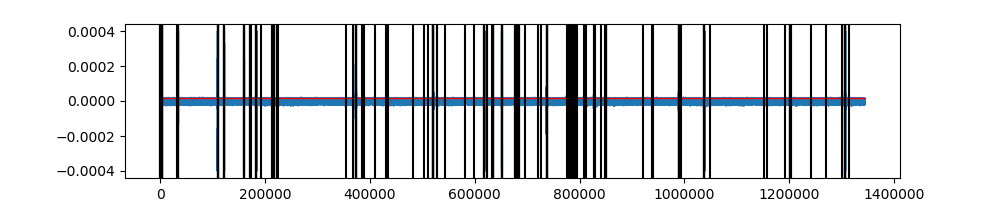

In [69]:
#PLOT STIM EVENTS AGAINST PLETH SIGNAL

#plot peak times in black onto session data 
plt.rcParams["figure.figsize"]= [10, 2]
plt.plot(plethdata) #plot the pleth signal for the whole session
lastindex = len(plethdata)-1
plt.plot([0, lastindex], [threshold, threshold], 'r-', lw=1)    #red line indicates threshold used to define events
for t in new_peaktimes:
    plt.axvline(x=t, color = 'k')
plt.show()

In [70]:
#CREATE AN EVENT ARRAY WHICH IS COMPATIBLE WITH MNE FUNCTIONS

new_peaktimes = np.int_(new_peaktimes)
secondcol = np.zeros(len(new_peaktimes),dtype='int32')   #Length of event (zero in this case)
thirdcol = np.ones(len(new_peaktimes),dtype='int32')     #Label of event type (all the same in this case)
peakevents = np.stack((new_peaktimes,secondcol,thirdcol),axis=-1)
print('dimensions of array are:', np.shape(peakevents))


dimensions of array are: (170, 3)


<IPython.core.display.Javascript object>


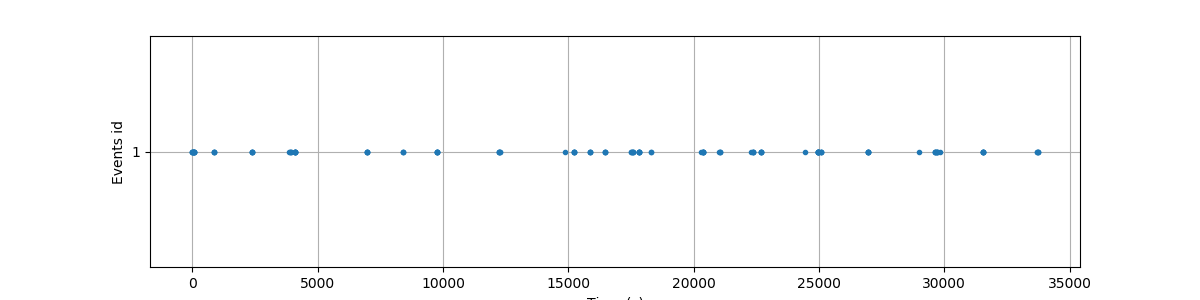

In [46]:
#PLOT STIM EVENTS ON TIME AXIS - USING MNE FUNCTION

fig = plt.rcParams["figure.figsize"]= [12, 3]
fig = mne.viz.plot_events(peakevents, sfreq= 50, first_samp=raw.first_samp)

In [71]:
#NEED TO RE-ADJUST (50Hz) TO 250Hz RAW SIGNAL
adj250_peakevents = np.copy(peakevents)
for i in range(len(new_peaktimes)):
    adj250_peakevents[i,0] = peakevents[i,0] * 5


In [72]:
#GENERATE EPOCHS

#Create Epochs Around Each Event
epochs = mne.Epochs(raw, adj250_peakevents,tmin=-20,tmax=30) #baseline: 20s before, response: 30s after stim
del raw #delete raw data to free memory
print(epochs)



170 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
<Epochs  |   170 events (good & bad), -20 - 30 sec, baseline [None, 0], ~28 kB, data not loaded,
 '1': 170>


Loading data for 170 events and 12501 original time points ...
3 bad epochs dropped
Loading data for 83 events and 12501 original time points ...


<IPython.core.display.Javascript object>


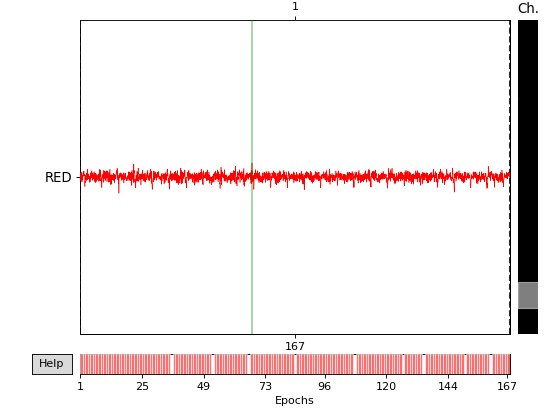

Loading data for 1 events and 12501 original time points ...


<IPython.core.display.Javascript object>


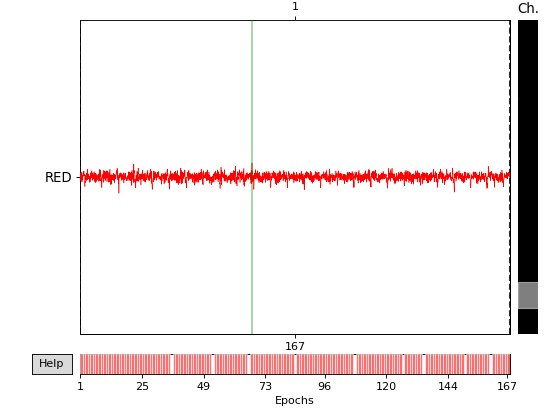

In [73]:
# VISUALLY INSPECT AND CLEAN EPOCHS WITH INTERACTIVE WINDOW

import matplotlib
%matplotlib notebook
mne.Epochs.plot(epochs, n_epochs = 1, n_channels = 1, block = True)


# NOTES FOR USE

# MANUAL IDENTIFY OSTENSIBLE STIMULUS TIMES PERTAINING TO REAL STIMULI 
# scroll up/down and select 'red' channel 
# scroll left/right to move across epochs. Clicking an epoch turns it red which denotes 'bad' epochs.
# bad epochs marked as 'USER' in epochs.drop_log.


In [74]:
# SAVE EPOCHED DATA 

os.chdir(r'C:\Users\rhyso\eegdata')
file_date = files[-12:-4]  #extract date from file name
file_name = 'epochs_GW_' + file_date + '-epo.fif'
print(file_name)   
mne.Epochs.save(epochs, file_name)


epochs_GW_13_12_19-epo.fif
Loading data for 1 events and 12501 original time points ...
Loading data for 9 events and 12501 original time points ...


<ipython-input-74-6333e00dc674>:7: DeprecationWarning: overwrite defaults to True in 0.18 but will change to False in 0.19, set it explicitly to avoid this warning
  mne.Epochs.save(epochs, file_name)
